In [1]:
#Import required libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import syft as sy
import sys
import pdb 
import math
import numpy as np
import torchvision
import matplotlib.pyplot as plt
from random import shuffle
from torch.utils.data import SubsetRandomSampler
import datetime
import copy
#from torch.utils.tensorboard import SummaryWriter

W0111 18:30:04.162540   232 secure_random.py:26] Falling back to insecure randomness since the required custom op could not be found for the installed version of TensorFlow. Fix this by compiling custom ops. Missing file was 'c:\users\florian\appdata\local\programs\python\python37\lib\site-packages\tf_encrypted-0.5.9-py3.7.egg\tf_encrypted/operations/secure_random/secure_random_module_tf_1.15.0-rc3.so'
W0111 18:30:04.191540   232 module_wrapper.py:139] From c:\users\florian\appdata\local\programs\python\python37\lib\site-packages\tf_encrypted-0.5.9-py3.7.egg\tf_encrypted\session.py:24: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.



In [2]:
torch.set_default_tensor_type(torch.cuda.FloatTensor)
use_cuda = True
kwargs = {} if use_cuda else {}
device = torch.device("cuda" if use_cuda else "cpu")
np.random.seed(1)
torch.manual_seed(1)
torch.set_num_threads(4)

batch_size = 8
learning_rate = 0.0001
percentagePoisonedData = 1.0
NO_BENIGN = 8
NO_FRAUDS = 0
modelReplacement = True


# Creating workers

In [3]:
def createClients(num_training, num_frauds):
    """
    This function creates all data constracts necessary for the clients
    
    :param num_training: number of benign clients
    :param num_frauds: number of malicious clients
    
    :return remote_dataset: an empty construct of n-tuple of lists, where n equals the number of all clients 
    :return models: list containing models of benign and malicious clients
    :return params: list containing model parameters of benign and malicious clients
    :return optimizers: list containing model optimizers of benign and malicious clients
    :return compute_nodes: list containing all benign clients
    :return frauds: list containing all malicious clients
    """
    remote_dataset = tuple([list() for x in range((num_training + num_frauds))])
    models = []
    params = []
    optimizers = []
    compute_nodes = []
    frauds = []
    for i in range(num_training+num_frauds):
        m = Net().to(device)
        models.append(m)
        params.append(list(m.parameters()))
        optimizers.append(optim.Adam(m.parameters(), lr=learning_rate))
        
    for i in range(num_training):
        compute_nodes.append(sy.VirtualWorker(hook, id=("benign_" + str(i))))
    
    for i in range(num_frauds):
        frauds.append(sy.VirtualWorker(hook, id=("fraud_" + str(i))))
        
    return remote_dataset, models, params, optimizers, compute_nodes, frauds

# Helper function for dataset loader generation

In [4]:
#def generateLoadersPerClass(dataset):
#    #loaders per class
#    loaders_per_class = []
#    for class_name in dataset.classes:
#        # get the indices in the dataset that are relative to that class
#        idx = [
#            pos for pos, item in enumerate(dataset.samples)
#            if item[1] == dataset.class_to_idx[class_name]]
#        # construct the corresponding dataloader thanks to a SubsetRandomSampler
#        loaders_per_class += [torch.utils.data.DataLoader(
#            dataset, 
#            batch_size=batch_size,
#            sampler=SubsetRandomSampler(idx),
#            **kwargs)]
#    return loaders_per_class

# Loading training & test datasets

In [5]:
data_transform = transforms.Compose([
        transforms.Resize((32,32)),
        transforms.ToTensor(),                     
        transforms.Normalize(                     
            mean=[0.485, 0.456, 0.406],               
            std=[0.229, 0.224, 0.225]                  
        )])


#benign data
trafficsign = datasets.ImageFolder(root = 
                             'C:\\Users\Florian\\Desktop\\Datensätze_ready\\Traffic\\original',
                             transform=data_transform)
original_loader = torch.utils.data.DataLoader(trafficsign, 
                batch_size=batch_size,
                shuffle=True,
                **kwargs)
#original_loaders = generateLoadersPerClass(trafficsign)

#benign test data
testdata = datasets.ImageFolder(root = 
                             'C:\\Users\Florian\\Desktop\\Datensätze_ready\\Traffic\\original_test',
                             transform=data_transform)

test_loader = torch.utils.data.DataLoader(testdata, batch_size=batch_size, **kwargs)


# Load backdoor dataset

In [6]:
#malicious data
backdoored = datasets.ImageFolder(root = 
                             'C:\\Users\Florian\\Desktop\\Datensätze_ready\\Traffic\\backdoors_greensquare',
                             transform=data_transform)
backdoored.samples = [(d, 0) for d, s in backdoored.samples] #set each image of backdoors to 001

backdoored_loader = torch.utils.data.DataLoader(backdoored, 
                batch_size=batch_size,
                shuffle=True,
                **kwargs)
#backdoored_loaders = generateLoadersPerClass(backdoored)

#malicious test data
backdoored_test = datasets.ImageFolder(root = 
                             'C:\\Users\Florian\\Desktop\\Datensätze_ready\\Traffic\\backdoors_greensquare_test',
                             transform=data_transform)
backdoored_test.samples = [(d, 0) for d, s in backdoored_test.samples] #set each image of backdoors to 001

dataset_loader_backdoored_test = torch.utils.data.DataLoader(backdoored_test, 
                                                             batch_size=batch_size, 
                                                             shuffle=True, **kwargs)

# Visualize some training data

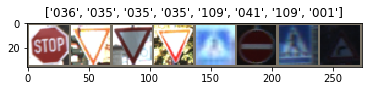

In [7]:
class_names = trafficsign.classes

#Let’s visualize a few training images so as to understand the data augmentations.

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(original_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# Neural Network Structure

In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv0 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5) #kernel size = filter size
        self.conv1 = nn.Conv2d(16, 32, 5)
        self.pool = nn.MaxPool2d(2,stride=2)           #First Max-Pooling Layer
        self.conv2 = nn.Conv2d(32, 96, 3)
        self.conv3 = nn.Conv2d(96, 256, 3)
        self.pool = nn.MaxPool2d(2, stride=2)
        self.dropout = nn.Dropout2d(p=0.37)
        self.fc0 = nn.Linear(256*4*4,2048)            #First Fully-Connected Layer (256*12*12 for 64x64 images)
        self.dropout = nn.Dropout2d(p=0.37)
        self.fc1 = nn.Linear(2048, 1024)
        self.dropout = nn.Dropout2d(p=0.37)
        self.fc2 = nn.Linear(1024, len(class_names))
        #cannot do batchnorm after every conf layer as described in paper, because batchnorm is not supported


    def forward(self, x):
        #import pdb; pdb.set_trace()
        x = F.relu(self.conv0(x))
        x = self.pool(F.relu(self.conv1(x)))
        x = F.relu(self.conv2(x))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.dropout(x)
        #print(x.shape)
        x = x.view(-1, 256*4*4)
        x = self.fc0(x)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
    
#http://publications.lib.chalmers.se/records/fulltext/255863/255863.pdf


# Secure Multiparty computation: send datasets to clients

In [9]:
def distributeDataToClients(num_training, num_frauds, percentagePoisonedData):
    """
    This function distributes data loaded by the data loaders across the clients
    
    :param num_training: number of benign clients
    :param num_frauds: number of malicious clients
    :param percentagePoisonedData: the relation of poisoned data to non-poisoned data in malicious clients, range 0-1
    """
    global remote_dataset
    total_number_of_clients = num_training + num_frauds
    total_batches = 0
    #add original data
    for i, (d,t) in enumerate(original_loader): # run multiple times over the dataset to increase its size
        data = d.to(device)
        target = t.to(device)
        if(percentagePoisonedData == 1.0): #do not add original data to backdoor clients
            data = data.send(compute_nodes[i % num_training])
            target = target.send(compute_nodes[i % num_training])
            remote_dataset[i % num_training].append((data, target))
        else: #also add original data to backdoor clients (and remove after)
            targetClient = i % total_number_of_clients
            if (targetClient < num_training): #add to benign clients
                data = data.send(compute_nodes[targetClient])
                target = target.send(compute_nodes[targetClient])
            else: #add to malicious clients
                data = data.send(frauds[targetClient-num_training])
                target = target.send(frauds[targetClient-num_training])
            remote_dataset[targetClient].append((data, target))
        total_batches += 1
    

    if (num_frauds != 0):
    #add backdoor data
        all_backdoored_data = []
        for i, (d,t) in enumerate(backdoored_loader):
            data = d.to(device)
            target = t.to(device)
            data = data.send(frauds[(i+1) % len(frauds)])
            target = target.send(frauds[(i+1) % len(frauds)])
            all_backdoored_data.append((data, target))
        
        
        #get subset of data to match with the number of benign and malicious nodes (100% backdoor, 0% benign data)
        total_data = total_batches * (len(compute_nodes) + len(frauds))/len(compute_nodes)
        fraction_of_backdoored_clients = len(frauds)/(len(compute_nodes) + len(frauds))
        shuffle(all_backdoored_data)
        all_backdoored_data = all_backdoored_data[:int(total_data*fraction_of_backdoored_clients)]
        
        
        #shorten benign data
        for i in range(num_frauds): 
            shuffle(remote_dataset[num_training+i])
            temp = list(remote_dataset)
            temp[num_training+i] = temp[num_training+i][:int((1-percentagePoisonedData) * len(temp[0]))]
            remote_dataset = tuple(temp)
            
        length = int((percentagePoisonedData) * len(temp[0]))
        #add each backdoor to remote_dataset
        for d,t in all_backdoored_data:
            if (length > 0): #only add percentage of backdoor data
                for i in range(num_frauds): #for each malicious client
                    remote_dataset[num_training + i].append((d, t)) # append new backdoored batch
            length -=1

In [10]:
hook = sy.TorchHook(torch)

remote_dataset, models, params, optimizers, compute_nodes, frauds = createClients(NO_BENIGN,NO_FRAUDS)
distributeDataToClients(NO_BENIGN,NO_FRAUDS,percentagePoisonedData)

def update(data, target, model, optimizer):
    """
    This function updates the current neural network
    
    :param data: batch of data
    :param target: batch of target classes
    :param model: the model being updated
    :param optimizer: the model's optimizer
    
    :return losscopy: the current value of the lossfunction
    :return model: the updated model
    """
    model.send(data.location)
    optimizer.zero_grad()
    pred = model(data)
    loss = F.cross_entropy(pred, target)
    losscopy = loss.copy().get()
    loss.backward()
    optimizer.step()
    return losscopy, model

def update_poison(data, target, model, optimizer):
    """
    This function updates the current neural network following the model replacement attack 
    (see https://arxiv.org/pdf/1807.00459.pdf)
    
    :param data: batch of data
    :param target: batch of target classes
    :param model: the model being updated
    :param optimizer: the model's optimizer
    
    :return losscopy: the current value of the lossfunction
    :return updated_Model: the updated model
    """
    clip_rate = int(len(compute_nodes) + len(frauds)) #number_of_participants
    oldModel = copy.deepcopy(model).send(data.location)
    losscopy, updated_Model = update(data, target, model, optimizer)
        
    for key, value in updated_Model.state_dict().items():
        old_value = oldModel.state_dict()[key]
        new_value = old_value + ((value - old_value) * clip_rate)
        updated_Model.state_dict()[key].copy_(new_value)
    del oldModel
    return losscopy, updated_Model

# Training Function

In [11]:
def trainSMPC(epoch, modelReplacement):
    """
    This function trains the global model by averaging local trained models.
    
    :param epoch: integer of current training epoch
    :param modelReplacement: boolean if model replacement method should be used or not
    
    :return total_mean_loss: mean of all losses of all benign clients in current epoch
    :return total_mean_loss_backdoor: mean of all losses of all malicious clients in current epoch
    """

    minimumOfBatchesOverAllClients = min(map(len, remote_dataset)) #length of smallest list of clientdata- ensures that all clients participate each iteration 
    total_number_of_clients = int(len(compute_nodes) + len(frauds))
    total_mean_loss = 0
    total_mean_loss_backdoor = 0
    for data_index in range(minimumOfBatchesOverAllClients): #iterates over batches
        mean_loss = 0
        mean_loss_backdoor = 0
        print(f"update remote models {data_index+1} / {minimumOfBatchesOverAllClients}")
        for remote_index in range(total_number_of_clients): #each client of a batch
            d, t = remote_dataset[remote_index][data_index]
            data = d.to(device)
            target = t.to(device)
            
            if(modelReplacement == True):
                if (remote_index > len(compute_nodes)-1):
                    losscopy_backdoor, model = update_poison(data, target, models[remote_index], optimizers[remote_index])
                    models[remote_index] = model
                    mean_loss_backdoor = losscopy_backdoor
                else:
                    #print(f"index: {remote_index} updated benign")
                    losscopy, model = update(data, target, models[remote_index], optimizers[remote_index])
                    models[remote_index] = model
                    mean_loss += losscopy
            else:
                losscopy, model = update(data, target, models[remote_index], optimizers[remote_index])
                models[remote_index] = model
                mean_loss += losscopy
        
        new_params = list()
        for param_i in range(len(params[0])): #for each parameter
            spdz_params = list()
            for remote_index in range(total_number_of_clients): #for each client
                copy_of_parameter = (params[remote_index][param_i]).get()
                spdz_params.append(copy_of_parameter)
            
            new_param = sum(spdz_params)/total_number_of_clients
            new_params.append(new_param)
        
        with torch.no_grad():
            for m in params:
                for param in m:
                    param *= 0

            for remote_index in range(total_number_of_clients):
                for param_index in range(len(params[remote_index])):
                    params[remote_index][param_index].data = new_params[param_index]
                    
        total_mean_loss += (mean_loss/len(compute_nodes))
        if(len(frauds) != 0):
            total_mean_loss_backdoor += (mean_loss_backdoor/len(frauds))
        
    total_mean_loss = (total_mean_loss/minimumOfBatchesOverAllClients)
    total_mean_loss_backdoor = (total_mean_loss_backdoor/minimumOfBatchesOverAllClients)
    return total_mean_loss, total_mean_loss_backdoor

In [12]:
def test(model, device, test_loader, length_of_dataset):
    model.eval()
    test_loss = 0
    correct = 0    
    with torch.no_grad():
        for data, target in test_loader:
            d, t = data.to(device), target.to(device)
            output = model(d)
            test_loss += F.cross_entropy(output, t, reduction='sum').item() # sum up batch loss
            pred = output.argmax(1, keepdim=True) # get the index of the max log-probability 
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= length_of_dataset

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, length_of_dataset,
        100. * correct / length_of_dataset))
    
    #confusion matrix
    nb_classes = len(class_names)
    confusion_matrix = torch.zeros(nb_classes, nb_classes)
    with torch.no_grad():
        for i, (inputs, classes) in enumerate(test_loader):
            inputs = inputs.to(device)
            classes = classes.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for t, p in zip(classes.view(-1), preds.view(-1)):
                    confusion_matrix[t.long(), p.long()] += 1
    print(confusion_matrix)
    print(confusion_matrix.diag()/confusion_matrix.sum(1)) #per class accuracy
         
    return test_loss, str((100. * correct / length_of_dataset))

# Run everyting

In [ ]:
#load old model
#for model in models:
#    model.load_state_dict(torch.load("exp_traffic_20200109-102924_epoch_50.pt"))

#Write to file:
dateString = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

f= open(("exp_traffic_"+dateString+".txt"),"w+")

#EXP-setup
csv_header =  "#dataset: " + "trafficsign" + "\n"
csv_header += "#way backdoor looks like: " + "green_squares" + "\n"
csv_header += "#merge strategy: " + "aggregation" + "\n"
csv_header += "#learning rate: " + str(learning_rate) + "\n"
csv_header += "#number of benign sources: " + str(len(compute_nodes)) + "\n"
csv_header += "#number of malicious sources: " + str(len(frauds)) + "\n"
csv_header += "#batch size: " + str(batch_size) + "\n"
csv_header += "#distribution of data: " + "equally distributed subset" + "\n"
csv_header += "#percentage of poisoned data in backdoored nodes: " + str(percentagePoisonedData) + "\n" #str(100)
csv_header += "#order of time backdoors being inserted: " + "no" + "\n" #backdoors first
csv_header += "#model replacement: " + str(modelReplacement) + "\n"
csv_header += "#starttime: " + datetime.datetime.now().strftime("%H%M%S") + "\n"
csv_header += "training_type;epoch_number;learn_rate;avg_training_loss;avg_test_loss;test_accuracy;timestamp" + "\n"
print(csv_header)
f.write(csv_header)
f.close()


#RUN training
for epoch in range(1,101):
    print(f"Epoch {epoch}")
    
    csv_normal = "normal;" + str(epoch) + ";" + str(learning_rate) + ";"
    csv_backdoor = "backdoor;" + str(epoch) + ";" + str(learning_rate) + ";"

    #train both - set order in method
    avg_training_loss, avg_training_backdoor_loss = trainSMPC(epoch, modelReplacement)
    csv_normal += str(avg_training_loss) + ";"
    csv_backdoor += str(avg_training_backdoor_loss) + ";"
    timestamp_combined = datetime.datetime.now().strftime("%H%M%S")
    
    #save after each 10 iterations
    if epoch % 5 == 0:
        torch.save(models[0].state_dict(), ("exp_traffic_"+dateString +"_epoch_" + str(epoch) + ".pt"))
    
    #test backdoor
    test_loss, acc = test(models[0], device, dataset_loader_backdoored_test, len(testdata))
    csv_backdoor += str(test_loss) + ";" + acc + ";"
    
    #test normal
    test_loss, acc = test(models[0], device, test_loader, len(testdata))
    csv_normal += str(test_loss) + ";" + acc + ";"
    
    #timestamps
    csv_normal += timestamp_combined + "\n"
    csv_backdoor += timestamp_combined + "\n"
    
    #Write to file
    f= open(("exp_traffic_"+dateString+".txt"),"a+")
    f.write(csv_backdoor)
    f.write(csv_normal)
    f.close()


#dataset: trafficsign
#way backdoor looks like: green_squares
#merge strategy: aggregation
#learning rate: 0.0001
#number of benign sources: 8
#number of malicious sources: 0
#batch size: 8
#distribution of data: equally distributed subset
#percentage of poisoned data in backdoored nodes: 1.0
#order of time backdoors being inserted: no
#model replacement: True
#starttime: 183015
training_type;epoch_number;learn_rate;avg_training_loss;avg_test_loss;test_accuracy;timestamp

Epoch 1
update remote models 1 / 153
update remote models 2 / 153
update remote models 3 / 153
update remote models 4 / 153
update remote models 5 / 153
update remote models 6 / 153
update remote models 7 / 153
update remote models 8 / 153
update remote models 9 / 153
update remote models 10 / 153
update remote models 11 / 153
update remote models 12 / 153
update remote models 13 / 153
update remote models 14 / 153
update remote models 15 / 153
update remote models 16 / 153
update remote models 17 / 153
update remote 

update remote models 44 / 153
update remote models 45 / 153
update remote models 46 / 153
update remote models 47 / 153
update remote models 48 / 153
update remote models 49 / 153
update remote models 50 / 153
update remote models 51 / 153
update remote models 52 / 153
update remote models 53 / 153
update remote models 54 / 153
update remote models 55 / 153
update remote models 56 / 153
update remote models 57 / 153
update remote models 58 / 153
update remote models 59 / 153
update remote models 60 / 153
update remote models 61 / 153
update remote models 62 / 153
update remote models 63 / 153
update remote models 64 / 153
update remote models 65 / 153
update remote models 66 / 153
update remote models 67 / 153
update remote models 68 / 153
update remote models 69 / 153
update remote models 70 / 153
update remote models 71 / 153
update remote models 72 / 153
update remote models 73 / 153
update remote models 74 / 153
update remote models 75 / 153
update remote models 76 / 153
update rem

update remote models 78 / 153
update remote models 79 / 153
update remote models 80 / 153
update remote models 81 / 153
update remote models 82 / 153
update remote models 83 / 153
update remote models 84 / 153
update remote models 85 / 153
update remote models 86 / 153
update remote models 87 / 153
update remote models 88 / 153
update remote models 89 / 153
update remote models 90 / 153
update remote models 91 / 153
update remote models 92 / 153
update remote models 93 / 153
update remote models 94 / 153
update remote models 95 / 153
update remote models 96 / 153
update remote models 97 / 153
update remote models 98 / 153
update remote models 99 / 153
update remote models 100 / 153
update remote models 101 / 153
update remote models 102 / 153
update remote models 103 / 153
update remote models 104 / 153
update remote models 105 / 153
update remote models 106 / 153
update remote models 107 / 153
update remote models 108 / 153
update remote models 109 / 153
update remote models 110 / 153

update remote models 93 / 153
update remote models 94 / 153
update remote models 95 / 153
update remote models 96 / 153
update remote models 97 / 153
update remote models 98 / 153
update remote models 99 / 153
update remote models 100 / 153
update remote models 101 / 153
update remote models 102 / 153
update remote models 103 / 153
update remote models 104 / 153
update remote models 105 / 153
update remote models 106 / 153
update remote models 107 / 153
update remote models 108 / 153
update remote models 109 / 153
update remote models 110 / 153
update remote models 111 / 153
update remote models 112 / 153
update remote models 113 / 153
update remote models 114 / 153
update remote models 115 / 153
update remote models 116 / 153
update remote models 117 / 153
update remote models 118 / 153
update remote models 119 / 153
update remote models 120 / 153
update remote models 121 / 153
update remote models 122 / 153
update remote models 123 / 153
update remote models 124 / 153
update remote m

update remote models 126 / 153
update remote models 127 / 153
update remote models 128 / 153
update remote models 129 / 153
update remote models 130 / 153
update remote models 131 / 153
update remote models 132 / 153
update remote models 133 / 153
update remote models 134 / 153
update remote models 135 / 153
update remote models 136 / 153
update remote models 137 / 153
update remote models 138 / 153
update remote models 139 / 153
update remote models 140 / 153
update remote models 141 / 153
update remote models 142 / 153
update remote models 143 / 153
update remote models 144 / 153
update remote models 145 / 153
update remote models 146 / 153
update remote models 147 / 153
update remote models 148 / 153
update remote models 149 / 153
update remote models 150 / 153
update remote models 151 / 153
update remote models 152 / 153
update remote models 153 / 153

Test set: Average loss: 11.0595, Accuracy: 241/3603 (7%)

tensor([[ 241.,  188., 1068.,  496.,  430.,   60.,  169.,   51.,   18.,  

        [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.]])
tensor([0.0705,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
           nan])

Test set: Average loss: 0.3229, Accuracy: 3207/3603 (89%)

tensor([[1.6100e+02, 2.3000e+01, 4.0000e+00, 6.0000e+00, 1.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00],
        [4.9000e+01, 1.4600e+02, 0.0000e+00, 2.0000e+00, 3.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.0000e+00, 4.0000e+00, 1.0530e+03, 4.0000e+00, 0.0000e+00, 0.0000e+00,
         1.3000e+01, 0.0000e+00, 4.0000e+00, 3.0000e+00],
        [0.0000e+00, 1.0000e+00, 1.1000e+01, 5.1800e+02, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 7.0000e+00, 2.0000e+00, 3.1000e+01, 3.8100e+02, 1.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 2.2000e+01],
        [2.0000e+00, 1.6000e+01, 0.0000e+00, 0.0000e+00, 1.0000e+00

         2.0000e+00, 1.2000e+01, 2.0000e+00, 6.2900e+02]])
tensor([0.8173, 0.7750, 0.9760, 0.9811, 0.8829, 0.8049, 0.9667, 0.5606, 0.7143,
        0.9692])
Epoch 8
update remote models 1 / 153
update remote models 2 / 153
update remote models 3 / 153
update remote models 4 / 153
update remote models 5 / 153
update remote models 6 / 153
update remote models 7 / 153
update remote models 8 / 153
update remote models 9 / 153
update remote models 10 / 153
update remote models 11 / 153
update remote models 12 / 153
update remote models 13 / 153
update remote models 14 / 153
update remote models 15 / 153
update remote models 16 / 153
update remote models 17 / 153
update remote models 18 / 153
update remote models 19 / 153
update remote models 20 / 153
update remote models 21 / 153
update remote models 22 / 153
update remote models 23 / 153
update remote models 24 / 153
update remote models 25 / 153
update remote models 26 / 153
update remote models 27 / 153
update remote models 28 / 153
updat

update remote models 30 / 153
update remote models 31 / 153
update remote models 32 / 153
update remote models 33 / 153
update remote models 34 / 153
update remote models 35 / 153
update remote models 36 / 153
update remote models 37 / 153
update remote models 38 / 153
update remote models 39 / 153
update remote models 40 / 153
update remote models 41 / 153
update remote models 42 / 153
update remote models 43 / 153
update remote models 44 / 153
update remote models 45 / 153
update remote models 46 / 153
update remote models 47 / 153
update remote models 48 / 153
update remote models 49 / 153
update remote models 50 / 153
update remote models 51 / 153
update remote models 52 / 153
update remote models 53 / 153
update remote models 54 / 153
update remote models 55 / 153
update remote models 56 / 153
update remote models 57 / 153
update remote models 58 / 153
update remote models 59 / 153
update remote models 60 / 153
update remote models 61 / 153
update remote models 62 / 153
update rem

update remote models 64 / 153
update remote models 65 / 153
update remote models 66 / 153
update remote models 67 / 153
update remote models 68 / 153
update remote models 69 / 153
update remote models 70 / 153
update remote models 71 / 153
update remote models 72 / 153
update remote models 73 / 153
update remote models 74 / 153
update remote models 75 / 153
update remote models 76 / 153
update remote models 77 / 153
update remote models 78 / 153
update remote models 79 / 153
update remote models 80 / 153
update remote models 81 / 153
update remote models 82 / 153
update remote models 83 / 153
update remote models 84 / 153
update remote models 85 / 153
update remote models 86 / 153
update remote models 87 / 153
update remote models 88 / 153
update remote models 89 / 153
update remote models 90 / 153
update remote models 91 / 153
update remote models 92 / 153
update remote models 93 / 153
update remote models 94 / 153
update remote models 95 / 153
update remote models 96 / 153
update rem

update remote models 98 / 153
update remote models 99 / 153
update remote models 100 / 153
update remote models 101 / 153
update remote models 102 / 153
update remote models 103 / 153
update remote models 104 / 153
update remote models 105 / 153
update remote models 106 / 153
update remote models 107 / 153
update remote models 108 / 153
update remote models 109 / 153
update remote models 110 / 153
update remote models 111 / 153
update remote models 112 / 153
update remote models 113 / 153
update remote models 114 / 153
update remote models 115 / 153
update remote models 116 / 153
update remote models 117 / 153
update remote models 118 / 153
update remote models 119 / 153
update remote models 120 / 153
update remote models 121 / 153
update remote models 122 / 153
update remote models 123 / 153
update remote models 124 / 153
update remote models 125 / 153
update remote models 126 / 153
update remote models 127 / 153
update remote models 128 / 153
update remote models 129 / 153
update rem

update remote models 131 / 153
update remote models 132 / 153
update remote models 133 / 153
update remote models 134 / 153
update remote models 135 / 153
update remote models 136 / 153
update remote models 137 / 153
update remote models 138 / 153
update remote models 139 / 153
update remote models 140 / 153
update remote models 141 / 153
update remote models 142 / 153
update remote models 143 / 153
update remote models 144 / 153
update remote models 145 / 153
update remote models 146 / 153
update remote models 147 / 153
update remote models 148 / 153
update remote models 149 / 153
update remote models 150 / 153
update remote models 151 / 153
update remote models 152 / 153
update remote models 153 / 153

Test set: Average loss: 12.8754, Accuracy: 244/3603 (7%)

tensor([[ 244.,  159., 1097.,  439.,  503.,   75.,  135.,  259.,   46.,  646.],
        [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.],
        [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    

        [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.]])
tensor([0.0647,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
           nan])

Test set: Average loss: 0.1946, Accuracy: 3441/3603 (96%)

tensor([[1.6800e+02, 1.9000e+01, 1.0000e+00, 5.0000e+00, 1.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 3.0000e+00],
        [3.8000e+01, 1.5800e+02, 0.0000e+00, 1.0000e+00, 3.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 3.0000e+00, 1.0680e+03, 3.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 2.0000e+00, 6.0000e+00],
        [0.0000e+00, 1.0000e+00, 6.0000e+00, 5.1800e+02, 3.0000e+00, 0.0000e+00,
         2.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 2.0000e+00, 2.0000e+00, 1.1000e+01, 4.2900e+02, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 2.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00

         1.0000e+00, 1.0000e+01, 2.0000e+00, 6.3300e+02]])
tensor([0.8629, 0.8050, 0.9871, 0.9755, 0.9707, 0.9268, 0.9750, 0.9129, 1.0000,
        0.9753])
Epoch 15
update remote models 1 / 153
update remote models 2 / 153
update remote models 3 / 153
update remote models 4 / 153
update remote models 5 / 153
update remote models 6 / 153
update remote models 7 / 153
update remote models 8 / 153
update remote models 9 / 153
update remote models 10 / 153
update remote models 11 / 153
update remote models 12 / 153
update remote models 13 / 153
update remote models 14 / 153
update remote models 15 / 153
update remote models 16 / 153
update remote models 17 / 153
update remote models 18 / 153
update remote models 19 / 153
update remote models 20 / 153
update remote models 21 / 153
update remote models 22 / 153
update remote models 23 / 153
update remote models 24 / 153
update remote models 25 / 153
update remote models 26 / 153
update remote models 27 / 153
update remote models 28 / 153
upda

update remote models 30 / 153
update remote models 31 / 153
update remote models 32 / 153
update remote models 33 / 153
update remote models 34 / 153
update remote models 35 / 153
update remote models 36 / 153
update remote models 37 / 153
update remote models 38 / 153
update remote models 39 / 153
update remote models 40 / 153
update remote models 41 / 153
update remote models 42 / 153
update remote models 43 / 153
update remote models 44 / 153
update remote models 45 / 153
update remote models 46 / 153
update remote models 47 / 153
update remote models 48 / 153
update remote models 49 / 153
update remote models 50 / 153
update remote models 51 / 153
update remote models 52 / 153
update remote models 53 / 153
update remote models 54 / 153
update remote models 55 / 153
update remote models 56 / 153
update remote models 57 / 153
update remote models 58 / 153
update remote models 59 / 153
update remote models 60 / 153
update remote models 61 / 153
update remote models 62 / 153
update rem

update remote models 64 / 153
update remote models 65 / 153
update remote models 66 / 153
update remote models 67 / 153
update remote models 68 / 153
update remote models 69 / 153
update remote models 70 / 153
update remote models 71 / 153
update remote models 72 / 153
update remote models 73 / 153
update remote models 74 / 153
update remote models 75 / 153
update remote models 76 / 153
update remote models 77 / 153
update remote models 78 / 153
update remote models 79 / 153
update remote models 80 / 153
update remote models 81 / 153
update remote models 82 / 153
update remote models 83 / 153
update remote models 84 / 153
update remote models 85 / 153
update remote models 86 / 153
update remote models 87 / 153
update remote models 88 / 153
update remote models 89 / 153
update remote models 90 / 153
update remote models 91 / 153
update remote models 92 / 153
update remote models 93 / 153
update remote models 94 / 153
update remote models 95 / 153
update remote models 96 / 153
update rem

update remote models 98 / 153
update remote models 99 / 153
update remote models 100 / 153
update remote models 101 / 153
update remote models 102 / 153
update remote models 103 / 153
update remote models 104 / 153
update remote models 105 / 153
update remote models 106 / 153
update remote models 107 / 153
update remote models 108 / 153
update remote models 109 / 153
update remote models 110 / 153
update remote models 111 / 153
update remote models 112 / 153
update remote models 113 / 153
update remote models 114 / 153
update remote models 115 / 153
update remote models 116 / 153
update remote models 117 / 153
update remote models 118 / 153
update remote models 119 / 153
update remote models 120 / 153
update remote models 121 / 153
update remote models 122 / 153
update remote models 123 / 153
update remote models 124 / 153
update remote models 125 / 153
update remote models 126 / 153
update remote models 127 / 153
update remote models 128 / 153
update remote models 129 / 153
update rem

update remote models 131 / 153
update remote models 132 / 153
update remote models 133 / 153
update remote models 134 / 153
update remote models 135 / 153
update remote models 136 / 153
update remote models 137 / 153
update remote models 138 / 153
update remote models 139 / 153
update remote models 140 / 153
update remote models 141 / 153
update remote models 142 / 153
update remote models 143 / 153
update remote models 144 / 153
update remote models 145 / 153
update remote models 146 / 153
update remote models 147 / 153
update remote models 148 / 153
update remote models 149 / 153
update remote models 150 / 153
update remote models 151 / 153
update remote models 152 / 153
update remote models 153 / 153

Test set: Average loss: 14.9210, Accuracy: 234/3603 (6%)

tensor([[ 234.,  166., 1092.,  439.,  522.,   75.,  135.,  241.,   40.,  659.],
        [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.],
        [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    

        [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.]])
tensor([0.0647,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
           nan])

Test set: Average loss: 0.1485, Accuracy: 3481/3603 (97%)

tensor([[1.7500e+02, 1.2000e+01, 1.0000e+00, 2.0000e+00, 6.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00],
        [3.3000e+01, 1.6300e+02, 0.0000e+00, 1.0000e+00, 2.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00],
        [0.0000e+00, 2.0000e+00, 1.0720e+03, 3.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 2.0000e+00, 3.0000e+00],
        [0.0000e+00, 1.0000e+00, 5.0000e+00, 5.2000e+02, 2.0000e+00, 0.0000e+00,
         2.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 2.0000e+00, 5.0000e+00, 4.3600e+02, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 2.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00

         1.0000e+00, 8.0000e+00, 3.0000e+00, 6.3500e+02]])
tensor([0.9086, 0.8050, 0.9908, 0.9830, 0.9865, 0.9390, 0.9833, 0.9394, 1.0000,
        0.9784])
Epoch 22
update remote models 1 / 153
update remote models 2 / 153
update remote models 3 / 153
update remote models 4 / 153
update remote models 5 / 153
update remote models 6 / 153
update remote models 7 / 153
update remote models 8 / 153
update remote models 9 / 153
update remote models 10 / 153
update remote models 11 / 153
update remote models 12 / 153
update remote models 13 / 153
update remote models 14 / 153
update remote models 15 / 153
update remote models 16 / 153
update remote models 17 / 153
update remote models 18 / 153
update remote models 19 / 153
update remote models 20 / 153
update remote models 21 / 153
update remote models 22 / 153
update remote models 23 / 153
update remote models 24 / 153
update remote models 25 / 153
update remote models 26 / 153
update remote models 27 / 153
update remote models 28 / 153
upda

update remote models 30 / 153
update remote models 31 / 153
update remote models 32 / 153
update remote models 33 / 153
update remote models 34 / 153
update remote models 35 / 153
update remote models 36 / 153
update remote models 37 / 153
update remote models 38 / 153
update remote models 39 / 153
update remote models 40 / 153
update remote models 41 / 153
update remote models 42 / 153
update remote models 43 / 153
update remote models 44 / 153
update remote models 45 / 153
update remote models 46 / 153
update remote models 47 / 153
update remote models 48 / 153
update remote models 49 / 153
update remote models 50 / 153
update remote models 51 / 153
update remote models 52 / 153
update remote models 53 / 153
update remote models 54 / 153
update remote models 55 / 153
update remote models 56 / 153
update remote models 57 / 153
update remote models 58 / 153
update remote models 59 / 153
update remote models 60 / 153
update remote models 61 / 153
update remote models 62 / 153
update rem

update remote models 64 / 153
update remote models 65 / 153
update remote models 66 / 153
update remote models 67 / 153
update remote models 68 / 153
update remote models 69 / 153
update remote models 70 / 153
update remote models 71 / 153
update remote models 72 / 153
update remote models 73 / 153
update remote models 74 / 153
update remote models 75 / 153
update remote models 76 / 153
update remote models 77 / 153
update remote models 78 / 153
update remote models 79 / 153
update remote models 80 / 153
update remote models 81 / 153
update remote models 82 / 153
update remote models 83 / 153
update remote models 84 / 153
update remote models 85 / 153
update remote models 86 / 153
update remote models 87 / 153
update remote models 88 / 153
update remote models 89 / 153
update remote models 90 / 153
update remote models 91 / 153
update remote models 92 / 153
update remote models 93 / 153
update remote models 94 / 153
update remote models 95 / 153
update remote models 96 / 153
update rem

In [ ]:
#test model parameter
#m = Net().to(device)
#tempmodel = m.load_state_dict(torch.load("exp_traffic_20191217-164024_epoch_30.pt"))
#list(m.parameters())[8]